https://www.youtube.com/watch?v=4yOcsWg-7g8

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2 
from PIL import Image

In [4]:
if(torch.cuda.is_available()) :
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device) #cuda GeForce RTX 3090

cuda GeForce RTX 3090


Read a batch of training images along with their bounding boxes and lables.

in this examole, i use read only 1 image i.e batch_size = 1

(741, 530, 3)


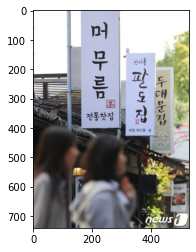

In [9]:
# input image could be any size
img0 = cv2.imread('test.jpg')                                        
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB) 
print(img0.shape)
plt.imshow(img0)
plt.show()

In [7]:

bbox0 = np.array([[160, 147, 260, 234], [139, 312, 200, 348]]) 
labels = np.array([1, 1]) # 0: background, 1: helmet

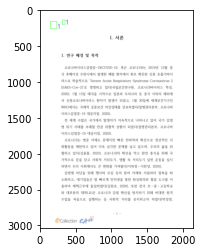

In [8]:
img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(0, 255, 0), thickness=3) 
    cv2.putText(img0_clone, str(int(labels[i])), (bbox0[i][3], bbox0[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) 
plt.imshow(img0_clone)
plt.show()   

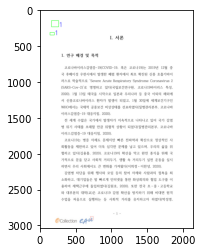

In [233]:
#display bounding box and labels
#cv2.putText
img0_clone = np.copy(img0)
for i in range(len(bbox0)) :
    cv2.rectangle(img0_clone, (bbox0[i][0], bbox0[i][1]), (bbox0[i][2], bbox0[i][3]), color = (0, 255, 0), thickness = 3)
    cv2.putText(img0_clone, str(int(labels[i])), (bbox0[i][2], bbox0[i][3]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), thickness = 3)
plt.imshow(img0_clone)
plt.show()

Resize the input images to (h = 800, w = 1200)

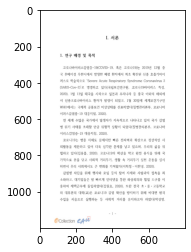

In [117]:
img = cv2.resize(img0, dsize = (800,1200), interpolation = cv2.INTER_CUBIC) #사이즈 변환
plt.imshow(img)
plt.show()

In [118]:
#change the bounding box coordinates
Wratio = 800/img0.shape[0]
Hratio = 1200/img0.shape[1]
ratioLst = [Hratio, Wratio, Hratio, Wratio]

bbox = []
for box in bbox0:
    box = [int(a*b) for a, b in zip(box, ratioLst)]
    bbox.append(box)
bbox = np.array(bbox)
print(bbox)

[[ 89  38 145  61]
 [ 77  82 111  91]]


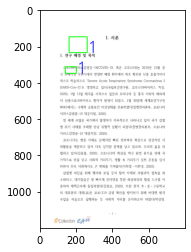

In [119]:
 #display bounding box and labels
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)) :
    cv2.rectangle(img_clone, (bbox0[i][0], bbox0[i][1]), (bbox0[i][2], bbox0[i][3]), color = (0, 255, 0), thickness = 3)
    cv2.putText(img_clone, str(int(labels[i])), (bbox0[i][2], bbox0[i][3]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), thickness = 3)
plt.imshow(img_clone)    
plt.show()


Use VGG16 to extract features from input image

In [228]:
#List all the layers of VGG16
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(len(fe))

31


In [231]:
#collect layers with output feature map size (W, H < 50)
dummy_img = torch.zeros((1, 3, 800, 1200)).float() #test image arrray(1,3,...)
print(dummy_img.shape)

req_feature = []
k = dummy_img.clone().to(device)
for i in fe :
    k = i(k)
    if k.size()[1] < 800//16 : #25
        breck
    req_feature.append(i)
    out_channels = k.size()[1]
print(len(req_feature))#31
print(out_channels)    #512

torch.Size([1, 3, 800, 1200])
31
512


In [94]:
#Conv this list into a Seq modul
faster_rcnn_fe_extractor = nn.Sequential(*req_feature)

In [122]:
transform = transforms.Compose([transforms.ToTensor()]) #Defing PyToech Transform
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 512, 37, 25])


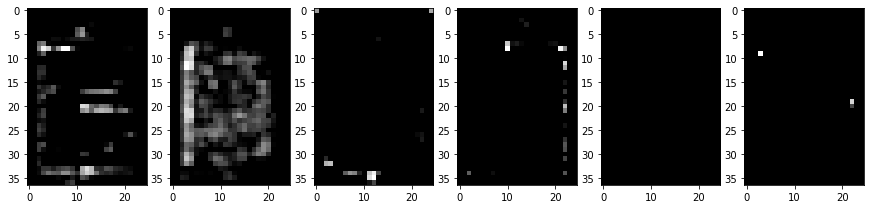

In [123]:
#visualize the first 5 channels of the 25*25*512 feature maps
imgArray = out_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize = (15, 4))
figNo = 1
for i in range(6) :
    fig.add_subplot(1, 6, figNo)
    plt.imshow(imgArray[i], cmap = 'gray')
    figNo +=1
plt.show()

Generate 22,500 anchor boxes on each input image
25x 25 = 750 anchors, each anchor generate 9 anchor boxes, Total = 25x 25x 9= 6750

In [124]:
# x, y, intervals to generate anchor box center
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1)*16, 16)
ctr_y = np.arange(16, (fe_size+1)*16, 16)
print(len(ctr_x), ctr_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [125]:
#coordinates of the 2500 center points to generate anchor boxes
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 0] = ctr_x[x] - 8
        ctr[index, 1] = ctr_y[y] - 8
        index +=1
print(ctr.shape)

(2500, 2)


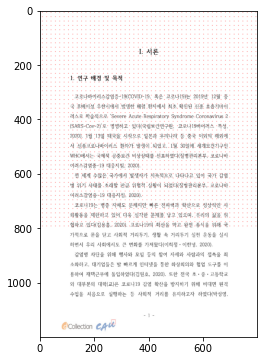

In [126]:
#display the 2500 anchors 9 anchor boxes are generated at an anchor point
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius = 1, color = (255, 0, 0), thickness = 1)
plt.imshow(img_clone)
plt.show()

In [127]:
#for each of the 2500 anchors, generate 9 anchor boxs
#2500*9 = 22500 anchor boxes
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
anchor_boxes = np.zeros( ((fe_size*fe_size*9), 4)) #50*50*9
index = 0
for c in ctr : #ctr = np.zeros((2500, 2))
    ctr_x, ctr_y = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            w = sub_sample * scales[j] * np.sqrt(1./ratios[i])
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            anchor_boxes[index, 0] = ctr_x - w / 2.
            anchor_boxes[index, 1] = ctr_y - h / 2.
            anchor_boxes[index, 2] = ctr_x + w / 2.
            anchor_boxes[index, 3] = ctr_y + h / 2.
            index += 1
print(anchor_boxes.shape)

(22500, 4)


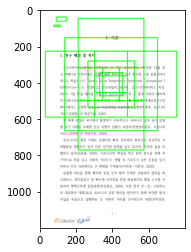

In [138]:
#display the 9 anchor boxes of one anchor and the grounf trugh bbox
img_clone = np.copy(img)
for i in range(11025, 11034): #9*1225 = 11025
    x0 = int(anchor_boxes[i][0])
    y0 = int(anchor_boxes[i][1])
    x1 = int(anchor_boxes[i][2])
    y1 = int(anchor_boxes[i][3])
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color = (0, 255, 0), thickness = 3)

for i in range(len(bbox)) :
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color = (0, 255, 0), thickness = 3) #Draw Ractangle

plt.imshow(img_clone)
plt.show()

valid anchor boxe ground truth bboxes iou

In [164]:
#Ignore cross - boundary abchor boxes
#vlaid anchor boxes with(x1, y1) > 0 and (x2, y2) <= 800
index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800)
    )[0]
print(index_inside.shape) #(8940,)

valid_anchor_boxes = anchor_boxes[index_inside]
print(vaild_anchor_boxes.shape) #(8940, 4)

(8940,)
(8940, 4)


In [165]:
#유효한 anchor상자 계산
#8940 개의 앵커 박스와 2 개의 Ground Truth 객체가 있으므로 (8490, 2)를 출력으로 배열을 얻어야합니다.
ious = np.empty((len(vaild_anchor_boxes), 2), dtype = np.float32)
ious.fill(0)
for num1, i in enumerate(vaild_anchor_boxes):
    xa1, ya1, xa2, ya2  = i
    anchor_area = (xa2-xa1)*(ya2 - ya1)
    for num2, j in enumerate(bbox) :
        xb1, yb1, xb2, yb2 = j
        box_area = (xb2-xb1)*(yb2 - yb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = max([xb2, xa2])
        inter_y2 = max([yb2, ya2])
        #iou 식
        if(inter_x1 < inter_x2) and (inter_y1 < inter_y2) : 
            iter_area = (inter_y2 - inter_y1)*(inter_x2 - inter_x1)
            iou = iter_area/(anchor_area+box_area - iter_area)
        else : 
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(8940, 2)


In [166]:
#iou수치가 최대인 anchor box찾기
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)#[2576 3527]

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)#[203.52795 856.67975]

[2576 3527]
[203.52795 856.67975]
[2576 2584 2822 2830 3068 3076 3314 3322 3527 3534 3541 3549 3557 3560
 3565 3568 3573 3580 3587 3594 3601 3608 3615 3752 3759 3766 3773 3773
 3780 3780 3787 3787 3795 3795 3803 3803 3806 3811 3811 3814 3819 3819
 3826 3826 3833 3833 3840 3840 3847 3847 3854 3854 3861 3861 4006 4014
 4022 4030 4030 4038 4038 4046 4046 4055 4055 4064 4064 4067 4073 4073
 4076 4082 4082 4090 4090 4098 4098 4106 4106 4114 4114 4122 4122 4130
 4130 4280 4288 4296 4304 4304 4312 4312 4320 4320 4329 4329 4338 4338
 4341 4347 4347 4350 4356 4356 4364 4364 4372 4372 4380 4380 4388 4388
 4396 4396 4404 4404 4554 4562 4570 4578 4578 4586 4586 4594 4594 4603
 4603 4612 4612 4615 4621 4621 4624 4630 4630 4638 4638 4646 4646 4654
 4654 4662 4662 4670 4670 4678 4678 4828 4836 4844 4852 4852 4860 4860
 4868 4868 4877 4877 4886 4886 4889 4895 4895 4898 4904 4904 4912 4912
 4920 4920 4928 4928 4936 4936 4944 4944 4952 4952 5094 5101 5108 5115
 5115 5122 5122 5129 5129 5137 5137 5145 51

In [167]:
# 각 앵커 박스와 관련된 Ground Truth bbox
argmax_ious = ious.argmax(axis = 1)
print(argmax_ious.shape) #(8940,)
print(argmax_ious) #[0 0 0 ... 1 1 1]
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious) #[ 0.9839553  1.2058405  1.3453476 ... 53.542484  53.542484  53.542484 ]

(8940,)
[0 0 0 ... 1 1 1]
[ 0.9839553  1.2058405  1.3453476 ... 53.542484  53.542484  53.542484 ]


iou 8940 valid anchor boxes ,1 : object, 0 : background, 01:ignore

In [169]:
label = np.empty((len(index_inside),), dtype = np.int32)
label.fill(-1)
print(label.shape)#(8940,)

(8940,)


In [170]:
#use iou to assign 1 (objects) to two kind of anchors
#a) The anchors with the highest iou overlap with a ground-truth-box
#b) An anchor that has an Iou overlap higher than 0.7 with ground-truth boxes
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

mini-batch training 256 baild abchor boxes RPN, 128 positive examples, 128 negative examples(0), valid anchor boxes mini-batch training -1 (ignore)

In [171]:
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample
n_pos = int(n_pos)


pos_index = np.where(label == 1)[0]
print(pos_index) #[   0    1    2 ... 8937 8938 8939]
print(n_pos) #128.0
if len(pos_index) > n_pos :
    disable_index = np.random.choice(pos_index, size = (len(pos_index) - n_pos), replace = False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label ==1)
neg_index = np.where(label == 0)[0]
if len(neg_index) > n_neg :
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    label[disable_index] = -1

[   0    1    2 ... 8937 8938 8939]
128


valid anchor boxes format (y1, x, y2, x2) loc = (cy-cya/ha, (cx- cxa/wa)log(h/ha), log(w/wa), RPN anchor box ground truth box ..?

In [218]:
#유효한 각 앵커 상자에 대해 max_iou가있는 groundtruth 객체를 찾습니다.
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)#(8940, 4)

# valid anchor boxes 的 h, w, cx, cy 
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

# valid anchor box 的 max iou 的 bbox 的 h, w, cx, cy 
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

# valid anchor boxes 的 loc = (y-ya/ha), (x-xa/wa), log(h/ha), log(w/wa)
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps) #讓 height !=0, 最小值為 eps
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)


(8940, 4)
(8940, 4)


22500 anchor boxes label = -1, location = 0. 8940 valid anchor boxes locations labels
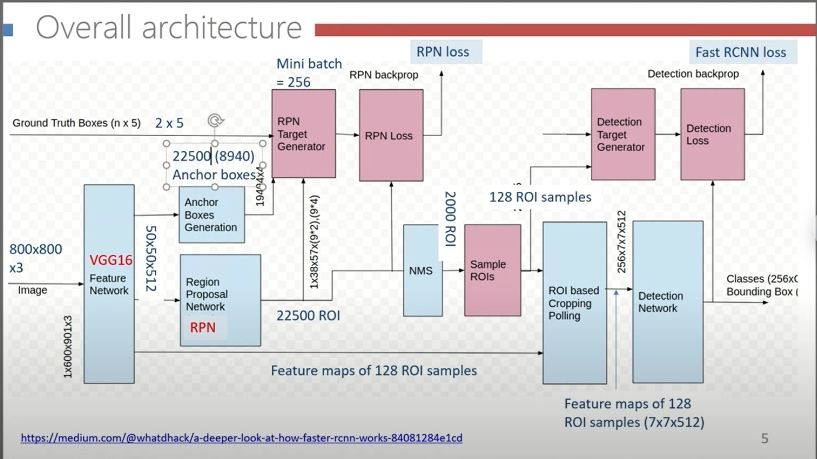

In [219]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)


(22500,)
(22500, 4)


RPN 22500ROI

In [220]:
in_channels = 512 # depends on the output feature map. in vgg 16 it is equal to 512
mid_channels = 512
n_anchor = 9  # Number of anchors at each location

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0).to(device) ## I will be going to use softmax here. you can equally use sigmoid if u replace 2 with 1.
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [226]:
x = conv1(out_map.to(device)) # out_map = faster_rcnn_fe_extractor(imgTensor)
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 37, 25]) torch.Size([1, 18, 37, 25])


In [227]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 8325, 4])
torch.Size([1, 37, 25, 18])


RuntimeError: shape '[1, 50, 50, 9, 2]' is invalid for input of size 16650